In [3]:
from scipy.io.wavfile import read
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
import soundfile as sf

In [2]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [8]:
test_wav_path = "/home/v-yuancwang/AudioEditing/hifigan_test_out/2ErfX6ZT5pM_generated.wav"
# wav, sr = load_wav(test_wav_path)
# wav = wav / MAX_WAV_VALUE
wav, sr = librosa.load(test_wav_path, sr=16000)
print(len(wav), sr)
wav = wav[:]
# print(wav)
wav = torch.FloatTensor(wav)
print(wav.unsqueeze(0).shape)
x = mel_spectrogram(wav.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
print(x.shape, x.max(), x.min())
print(x)

161611 16000
torch.Size([1, 161611])
torch.Size([1, 80, 631]) tensor(-0.8097) tensor(-11.5129)
tensor([[[ -8.4551,  -8.7732,  -8.8491,  ...,  -4.1312,  -4.6667,  -7.7846],
         [-10.8194, -11.3303, -11.0221,  ...,  -4.0948,  -5.0707,  -9.2719],
         [-11.0382, -11.5014, -10.5843,  ...,  -5.2366,  -5.7483,  -9.6218],
         ...,
         [-11.0465, -11.0269, -11.0791,  ...,  -7.4602,  -8.1741, -10.4206],
         [-11.5129, -11.5129, -11.5129,  ...,  -9.1527,  -9.9469, -11.5129],
         [-11.5129, -11.5129, -11.5129,  ..., -11.5129, -11.5129, -11.5129]]])


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
spec = x.cpu().numpy()[0]

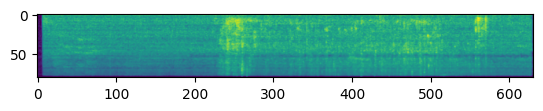

In [11]:
plt.imshow(spec)

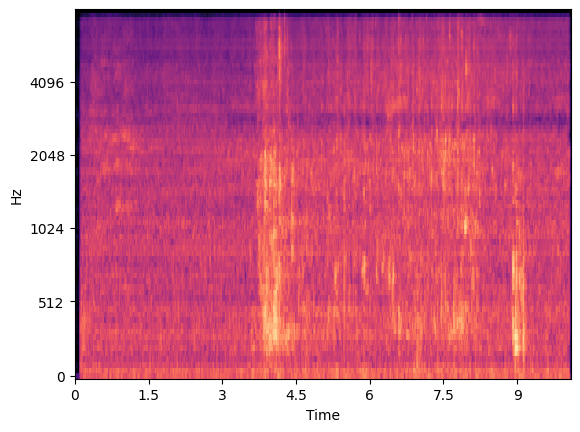

In [12]:
librosa.display.specshow(spec, sr=16000, hop_length=256, x_axis='time', y_axis='mel')
plt.show()

In [13]:
test_wav_path = "/home/v-yuancwang/AudioEditing/hifigan_test_wavs/2ErfX6ZT5pM.wav"
# wav, sr = load_wav(test_wav_path)
# wav = wav / MAX_WAV_VALUE
wav, sr = librosa.load(test_wav_path, sr=16000)
print(len(wav), sr)
wav = wav[:]
# print(wav)
wav = torch.FloatTensor(wav)
print(wav.unsqueeze(0).shape)
x = mel_spectrogram(wav.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
print(x.shape, x.max(), x.min())
print(x)

161792 16000
torch.Size([1, 161792])
torch.Size([1, 80, 632]) tensor(-0.8886) tensor(-11.5129)
tensor([[[-11.1347, -10.7868, -10.7777,  ...,  -5.2211,  -9.3022, -10.7643],
         [-10.5128, -11.0364, -10.7302,  ...,  -5.0966,  -9.5012, -10.5156],
         [-10.8792, -11.1472, -10.8551,  ...,  -5.4858,  -9.6324, -10.3712],
         ...,
         [-11.0939, -11.0783, -11.2523,  ...,  -7.8778,  -9.8817, -10.9484],
         [-10.9765, -11.0472, -10.9166,  ...,  -8.2530, -10.2573, -11.2061],
         [-11.1286, -11.0186, -11.0635,  ...,  -8.4035, -10.5624, -11.1080]]])


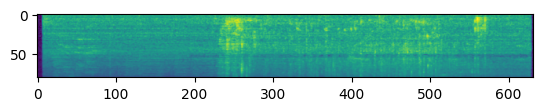

In [14]:
spec = x.cpu().numpy()[0]
plt.imshow(spec)

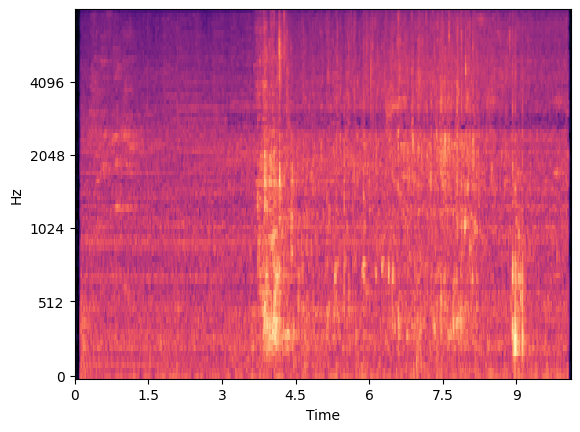

In [15]:
librosa.display.specshow(spec, sr=16000, hop_length=256, x_axis='time', y_axis='mel')
plt.show()